#Usage demo of *2D Lookup Table Generator*

#Language: Python3

Author: Neilay Khasnabish

Date: 17/10/2021

# 1. Use main script

In [1]:
'''
2D Lookup Table Generator
Author : Neilay Khasnabish
Date : 17/10/2021
Description : This script analyzes data, generates 2D lookup table, and compare outputs.
              This script generates 2D lookup table which is compatible with Simulink 2D
              lookup table
'''


# Python libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor


# Lookup table generator class
class lookup_table_generator :
    def __init__(self, dataMeasurementIP, dataMeasurementOP, tableAxesValues, dimensionTable = 2) :
        self.dimensionTable = dimensionTable
        self.dataMeasurementIP = dataMeasurementIP
        self.dataMeasurementOP = dataMeasurementOP
        self.tableAxesValues = tableAxesValues
        
    def checkData(self) :
        if self.dimensionTable != 2 :
            print('Error: Dimention of lookup table must be 2')
        else :
            dataMeasurementIP = self.dataMeasurementIP
            dataMeasurementOP = self.dataMeasurementOP
            tableAxesValues = self.tableAxesValues
            if dataMeasurementIP.isnull().values.any() or dataMeasurementOP.isnull().values.any() :
                print('Warning : Measurement data had NULL or undefined values')
                dataMeasurementIP = dataMeasurementIP.interpolate()
                dataMeasurementOP = dataMeasurementOP.interpolate()
            else :
                # Pandas to numpy array
                inputData = dataMeasurementIP.to_numpy()
                columnName = dataMeasurementIP.columns
                axesVal = tableAxesValues.to_numpy()
                outputData = dataMeasurementOP.to_numpy()
                # Plausibility check
                [rI, cI] = np.shape(inputData)
                [rO, cO] = np.shape(outputData)
                [rV, cV] = np.shape(axesVal)
                if cI == cV : 
                    if self.dimensionTable == cV :                        
                        # Check if data is sparse
                        seaborn.set(style='whitegrid')
                        columnNames = dataMeasurementIP.columns
                        seaborn.scatterplot(x=columnNames[0], y=columnNames[1], data=dataMeasurementIP)
                        plt.title('Quality of data is good if the complete grid is covered by the data points')                                                        
                    else : 
                        print('Error : Dimension of look up table must be same as columns of input data')
                else :
                    print('Error : Number of axes of lookup table must be same as columns of input data')

    def gridInterpolator(self, method = 'nearest') :
        if self.dimensionTable != 2 :
            print('Error: Dimention of lookup table must be 2')
        else :
            dataMeasurementIP = self.dataMeasurementIP
            dataMeasurementOP = self.dataMeasurementOP
            tableAxesValues = self.tableAxesValues
            if dataMeasurementIP.isnull().values.any() or dataMeasurementOP.isnull().values.any() :
                print('Warning : Measurement data had NULL or undefined values')
                dataMeasurementIP = dataMeasurementIP.interpolate()
                dataMeasurementOP = dataMeasurementOP.interpolate()
            else :
                # Pandas to numpy array
                inputData = dataMeasurementIP.to_numpy()
                columnName = dataMeasurementIP.columns
                axesVal = tableAxesValues.to_numpy()
                outputData = dataMeasurementOP.to_numpy()
                # Plausibility check
                [rI, cI] = np.shape(inputData)
                [rO, cO] = np.shape(outputData)
                [rV, cV] = np.shape(axesVal)
                if cI == cV : 
                    if self.dimensionTable == cV :
                        xAxis = axesVal[:,0] # Row : Input 1
                        yAxis = axesVal[:,1] # Column : Input 2
                        # 2D interpolation : Griddata
                        grid_x, grid_y = np.meshgrid(xAxis, yAxis)
                        grid_z0 = griddata(inputData, outputData, (grid_x, grid_y), method=method)
                        reshapedOP = grid_z0.reshape(int(len(xAxis)), int(len(yAxis)))
                        reshapedOP = np.transpose(reshapedOP)
                        # Calculating the ouputs from look up table
                        input1 = inputData[:,0] # Row
                        input2 = inputData[:,1] # Col
                        opCalc = []
                        for i in range(len(input1)) : # Input1 and Input2 length are same
                            dummyErr = 10000000000000000000
                            pos1 = 0
                            # Find the nearest match of input 1
                            for j1 in range(len(xAxis)) :
                                temp = np.abs(input1[i] - xAxis[j1])
                                if temp < dummyErr :
                                    pos1 = j1
                                    dummyErr = temp
                            dummyErr = 10000000000000000000
                            pos2 = 0
                            # Find the nearest match of input 2
                            for j2 in range(len(yAxis)) :
                                temp = np.abs(input2[i] - yAxis[j2])
                                if temp < dummyErr :
                                    pos2 = j2
                                    dummyErr = temp
                            # Nearest neighbour interpolation
                            opCalc.append(reshapedOP[int(pos1), int(pos2)])
                        maeErr = np.mean(np.abs(np.concatenate(outputData) - opCalc))  
                        maeErr = "{:.2f}".format(maeErr)
                        # Surfaceplot
                        fig = plt.figure()
                        ax = fig.gca(projection='3d')
                        surf = ax.plot_surface(grid_x, grid_y, reshapedOP, cmap=cm.coolwarm,
                                               linewidth=0, antialiased=False)
                        plt.xlabel(columnName[0])
                        plt.ylabel(columnName[1])
                        fig.colorbar(surf, shrink=0.8, aspect=5)
                        strTitle = ' '.join([str(method), ' | Mean Absolute Error: ', str(maeErr), ' unit'])
                        plt.title(strTitle)
                        plt.show()
                        # Series plot
                        plt.figure()
                        plt.plot(outputData, 'g')
                        plt.plot(opCalc, 'r')
                        plt.xlabel('Samples')
                        plt.ylabel('Magnitude')
                        plt.legend('Measurement data', 'Output of lookup table')
                        strTitle = ' '.join(['Validation by Nearest Neighbor Interp.', ' | MAE: ', str(maeErr), ' unit'])
                        plt.title(strTitle)
                        plt.show()
                        # Store result to text file
                        fileNew = open("gridDataLookUpTable.txt","w")
                        fileNew.write('Input1 : \n')
                        np.savetxt(fileNew, (np.transpose(xAxis)), fmt="%f")
                        fileNew.write('\nInput2 : \n')
                        np.savetxt(fileNew, (np.transpose(yAxis)), fmt="%f")
                        fileNew.write('\nGenerated lookup table : \n')
                        fileNew.write('[')
                        np.savetxt(fileNew, (reshapedOP), fmt="%f")
                        fileNew.write(']')
                        fileNew.close()                                
                    else :
                        print('Error : Dimension of lookup table must be same as columns of input data')
                else :
                    print('Error : Number of axes of lookup table must be same as columns of input data')
                    
    def linearInterpolator(self) :
            if self.dimensionTable != 2 :
                print('Error: Dimention of lookup table must be 2')
            else :
                dataMeasurementIP = self.dataMeasurementIP
                dataMeasurementOP = self.dataMeasurementOP
                tableAxesValues = self.tableAxesValues
                if dataMeasurementIP.isnull().values.any() or dataMeasurementOP.isnull().values.any() :
                    print('Warning : Measurement data had NULL or undefined values')
                    dataMeasurementIP = dataMeasurementIP.interpolate()
                    dataMeasurementOP = dataMeasurementOP.interpolate()
                else :
                    # Pandas to numpy array
                    inputData = dataMeasurementIP.to_numpy()
                    columnName = dataMeasurementIP.columns
                    axesVal = tableAxesValues.to_numpy()
                    outputData = dataMeasurementOP.to_numpy()
                    # Plausibility check
                    [rI, cI] = np.shape(inputData)
                    [rO, cO] = np.shape(outputData)
                    [rV, cV] = np.shape(axesVal)
                    if cI == cV : 
                        if self.dimensionTable == cV :
                            xAxis = axesVal[:,0] # Row : Input 1
                            yAxis = axesVal[:,1] # Column : Input 2
                            # 2D interpolation
                            grid_x, grid_y = np.meshgrid(xAxis, yAxis)                        
                            interp = LinearNDInterpolator(list(zip(inputData[:,0], inputData[:,1])), outputData)
                            grid_z0 = interp(grid_x, grid_y)
                            reshapedOP = grid_z0.reshape(int(len(xAxis)), int(len(yAxis)))
                            reshapedOP = np.transpose(reshapedOP)
                            # Calculating the ouputs from look up table
                            input1 = inputData[:,0] # Row
                            input2 = inputData[:,1] # Col
                            opCalc = []
                            for i in range(len(input1)) : # Input1 and Input2 length are same
                                dummyErr = 10000000000000000000
                                pos1 = 0
                                # Find the nearest match of input 1
                                for j1 in range(len(xAxis)) :
                                    temp = np.abs(input1[i] - xAxis[j1])
                                    if temp < dummyErr :
                                        pos1 = j1
                                        dummyErr = temp
                                dummyErr = 10000000000000000000
                                pos2 = 0
                                # Find the nearest match of input 2
                                for j2 in range(len(yAxis)) :
                                    temp = np.abs(input2[i] - yAxis[j2])
                                    if temp < dummyErr :
                                        pos2 = j2
                                        dummyErr = temp
                                # Nearest neighbour interpolation
                                opCalc.append(reshapedOP[int(pos1), int(pos2)])
                            maeErr = np.mean(np.abs(np.concatenate(outputData) - opCalc))  
                            maeErr = "{:.2f}".format(maeErr)
                            # Surfaceplot
                            fig = plt.figure()
                            ax = fig.gca(projection='3d')
                            surf = ax.plot_surface(grid_x, grid_y, reshapedOP, cmap=cm.coolwarm,
                                                   linewidth=0, antialiased=False)
                            plt.xlabel(columnName[0])
                            plt.ylabel(columnName[1])
                            fig.colorbar(surf, shrink=0.8, aspect=5)
                            strTitle = ' '.join([str('Linear Interp.'), ' | Mean Absolute Error: ', str(maeErr), ' unit'])
                            plt.title(strTitle)
                            plt.show()
                            # Series plot
                            plt.figure()
                            plt.plot(outputData, 'g')
                            plt.plot(opCalc, 'r')
                            plt.xlabel('Samples')
                            plt.ylabel('Magnitude')
                            plt.legend('Measurement data', 'Output of lookup table')
                            strTitle = ' '.join(['Validation by Nearest Neighbor Interp.', ' | MAE: ', str(maeErr), ' unit'])
                            plt.title(strTitle)
                            plt.show()
                            # Store result to text file
                            fileNew = open("linearLookUpTable.txt","w")
                            fileNew.write('Input1 : \n')
                            np.savetxt(fileNew, (np.transpose(xAxis)), fmt="%f")
                            fileNew.write('\nInput2 : \n')
                            np.savetxt(fileNew, (np.transpose(yAxis)), fmt="%f")
                            fileNew.write('\nGenerated lookup table : \n')
                            fileNew.write('[')
                            np.savetxt(fileNew, (reshapedOP), fmt="%f")
                            fileNew.write(']')
                            fileNew.close()                                
                        else : 
                            print('Error : Dimension of lookup table must be same as columns of input data')
                    else :
                        print('Error : Number of axes of lookup table must be same as columns of input data')

    def dtInterpolator(self, treeDepth = 10, estimatorSize = 500, learnRate = 0.001) :
            if self.dimensionTable != 2 :
                print('Error: Dimention of lookup table must be 2')
            else :
                dataMeasurementIP = self.dataMeasurementIP
                dataMeasurementOP = self.dataMeasurementOP
                tableAxesValues = self.tableAxesValues
                if dataMeasurementIP.isnull().values.any() or dataMeasurementOP.isnull().values.any() :
                    print('Warning : Measurement data had NULL or undefined values')
                    dataMeasurementIP = dataMeasurementIP.interpolate()
                    dataMeasurementOP = dataMeasurementOP.interpolate()
                else :
                    # Pandas to numpy array
                    inputData = dataMeasurementIP.to_numpy()
                    columnName = dataMeasurementIP.columns
                    axesVal = tableAxesValues.to_numpy()
                    outputData = dataMeasurementOP.to_numpy()
                    # Plausibility check
                    [rI, cI] = np.shape(inputData)
                    [rO, cO] = np.shape(outputData)
                    [rV, cV] = np.shape(axesVal)
                    if cI == cV : 
                        if self.dimensionTable == cV :
                            xAxis = axesVal[:,0] # Row : Input 1
                            yAxis = axesVal[:,1] # Column : Input 2
                            grid_x, grid_y = np.meshgrid(xAxis, yAxis) 
                            # Train Decision tree
                            print('Training started')
                            mdl = DecisionTreeRegressor(max_depth=treeDepth)
                            regrMdl = AdaBoostRegressor(base_estimator=mdl, 
                                                        n_estimators=estimatorSize, 
                                                        learning_rate=learnRate)
                            regrMdl.fit(inputData, np.ravel(outputData))
                            # Create table
                            reshapedOP = np.zeros((int(len(xAxis)), int(len(yAxis))))
                            print('Generation started')
                            for i1 in range(len(xAxis)) :
                                for j1 in range(len(xAxis)) :
                                    Ip = np.array([xAxis[i1], yAxis[j1]])
                                    Ip = Ip.reshape(1,2)
                                    reshapedOP[i1, j1] = regrMdl.predict(Ip)
                            print('All done')
                            # Calculating the ouputs from look up table
                            input1 = inputData[:,0] # Row
                            input2 = inputData[:,1] # Col
                            opCalc = []
                            for i in range(len(input1)) : # Input1 and Input2 length are same
                                dummyErr = 10000000000000000000
                                pos1 = 0
                                # Find the nearest match of xAxis
                                for j1 in range(len(xAxis)) :
                                    temp = np.abs(input1[i] - xAxis[j1])
                                    if temp < dummyErr :
                                        pos1 = j1
                                        dummyErr = temp
                                dummyErr = 10000000000000000000
                                pos2 = 0
                                # Find the nearest match of yAxis
                                for j2 in range(len(yAxis)) :
                                    temp = np.abs(input2[i] - yAxis[j2])
                                    if temp < dummyErr :
                                        pos2 = j2
                                        dummyErr = temp
                                # Nearest neighbour interpolation
                                opCalc.append(reshapedOP[int(pos1), int(pos2)])
                            maeErr = np.mean(np.abs(np.concatenate(outputData) - opCalc))   
                            maeErr = "{:.2f}".format(maeErr)
                            # Surfaceplot
                            fig = plt.figure()
                            ax = fig.gca(projection='3d')
                            surf = ax.plot_surface(grid_x, grid_y, reshapedOP, cmap=cm.coolwarm,
                                                   linewidth=0, antialiased=False)
                            plt.xlabel(columnName[0])
                            plt.ylabel(columnName[1])
                            fig.colorbar(surf, shrink=0.8, aspect=5)
                            strTitle = ' '.join([str('Decision Tree Interp.'), ' | Mean Absolute Error: ', str(maeErr), ' unit'])
                            plt.title(strTitle)
                            plt.show()
                            # Series plot
                            plt.figure()
                            plt.plot(outputData, 'g')
                            plt.plot(opCalc, 'r')
                            plt.xlabel('Samples')
                            plt.ylabel('Magnitude')
                            plt.legend('Measurement data', 'Output of lookup table')
                            strTitle = ' '.join(['Validation by Nearest Neighbor Interp.', ' | MAE: ', str(maeErr), ' unit'])
                            plt.title(strTitle)
                            plt.show()
                            # Store result to text file
                            fileNew = open("decisionTreeLookUpTable.txt","w")
                            fileNew.write('Input1 : \n')
                            np.savetxt(fileNew, (np.transpose(xAxis)), fmt="%f")
                            fileNew.write('\nInput2 : \n')
                            np.savetxt(fileNew, (np.transpose(yAxis)), fmt="%f")
                            fileNew.write('\nGenerated lookup table : \n')
                            fileNew.write('[')
                            np.savetxt(fileNew, (reshapedOP), fmt="%f")
                            fileNew.write(']')
                            fileNew.close()                                
                        else : 
                            print('Error : Dimension of lookup table must be same as columns of input data')
                    else :
                        print('Error : Number of axes of lookup table must be same as columns of input data')

# 2. Read data from *data.xlsx*

In [2]:
fileAddr = 'https://raw.githubusercontent.com/neilay-khasnabish/2D_Look_Up_Table_Generator/main/Data.xlsx'

# Format of measurement input data
dataMeasurementIP = pd.read_excel(fileAddr, 'ActualDataInput')

# Format of measurement output data
dataMeasurementOP = pd.read_excel(fileAddr, 'ActualDataOutput')

# Format of Input1 and Input2 axes values
tableAxesValues = pd.read_excel(fileAddr, 'LookupTableAxes')

# Please have a look at the *Data.xlsx* file attached to the Github repo to understand the format of inputs

# 3. Create class

In [3]:
lookup_table_class = lookup_table_generator(dataMeasurementIP, dataMeasurementOP, tableAxesValues)

# 4. Check quality of data

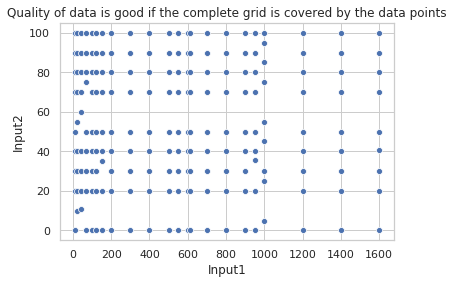

In [4]:
lookup_table_class.checkData()

### **Explanation of the above image**: If the data points are spread over the entire grid, the quality of data is good. If the data is spread diagonally or does not cover the entire range, the quality of data is not good to create the 2D lookup table. The above figure is an example of good data. The blue dots are the data points.

# 5. Generate lookup table with different algorithms

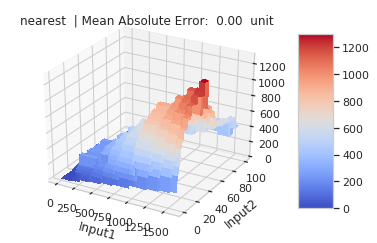

/usr/local/lib/python2.7/dist-packages/matplotlib/legend.py:937: UserWarning: Legend does not support 'M' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python2.7/dist-packages/matplotlib/legend.py:937: UserWarning: Legend does not support 'e' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python2.7/dist-packages/matplotlib/legend.py:937: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)
/usr/local/lib/python2.7/dist-packages/matp

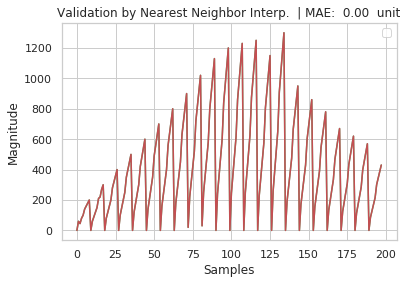

In [5]:
# Grid based method : 'nearest', 'linear', 'cubic'
lookup_table_class.gridInterpolator(method = 'nearest')



# **Explanation of the above image**: Nearest neighbour approach fits the look up table. The MAE (Mean Absolute Error) tells the quality of the fit.

/usr/local/lib/python2.7/dist-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


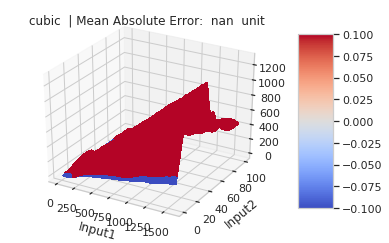

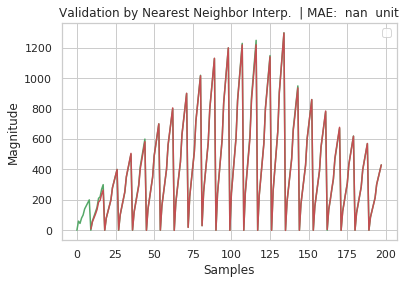

In [6]:
# Grid based method : 'nearest', 'linear', 'cubic'
lookup_table_class.gridInterpolator(method = 'cubic')

# **Explanation of the above image**: Cubic approach does not fit the look up table. The MAE (Mean Absolute Error) tells the quality of the fit.

Training started
Generation started
All done


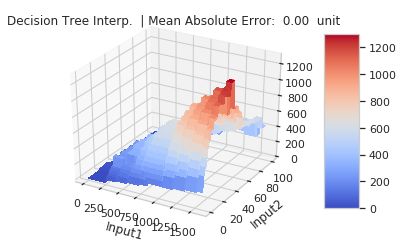

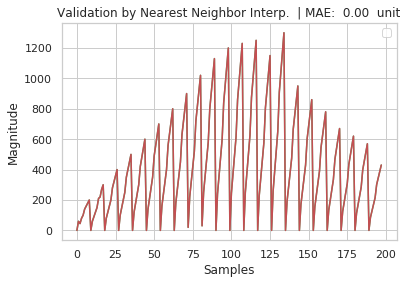

In [7]:
# The arguments are: depth of the tree, number of estimators, and learning rate
# The arguments are the tuning parameters of the Decision Tree Regressor
# These tuning parameters can be adjusted to avoid overfit and underfit
lookup_table_class.dtInterpolator(50, 250, 0.001)

# **Explanation of the above image**: Decision tree based approach fits the look up table. The MAE (Mean Absolute Error) tells the quality of the fit.

# 6. Other ways to give inputs

In [8]:
# Input and output measurement data can be read as pandas dataframe

# Format of measurement input data read in terms of pandas dataframe from Excel or CSV
# dataMeasurementIP = pd.read_excel(fileName, 'ActualDataInput')

# Format of measurement output data read in terms of pandas dataframe from Excel or CSV
# dataMeasurementOP = pd.read_excel(fileName, 'ActualDataOutput')

# Format of Input1 and Input2 axes values read in terms of pandas dataframe from Excel or CSV
tableAxesValues = pd.read_excel(fileAddr, 'LookupTableAxes')

# Another way to generate the Input1 and Input2 axes values (points where interpolation to be made)
Input1 = np.linspace(0, 1600, num=100)
Input2 = np.linspace(0, 100, num=100)
# Length of Input1 and Input2 must be same for Grid based interpolation
print(len(Input1), len(Input2))

# Create pandas dataframe
data = {'Input1' : Input1, 'Input2' : Input2}
tableAxesValues = pd.DataFrame(data = data)
print(tableAxesValues.head())
lookup_table_class = lookup_table_generator(dataMeasurementIP, dataMeasurementOP, tableAxesValues)

(100, 100)
      Input1    Input2
0   0.000000  0.000000
1  16.161616  1.010101
2  32.323232  2.020202
3  48.484848  3.030303
4  64.646465  4.040404


# Let us check the interpolation with the Neirest Neighbor approach

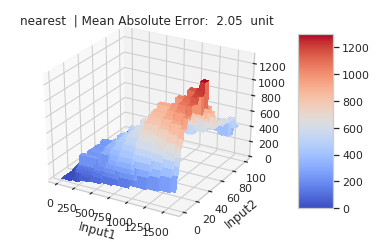

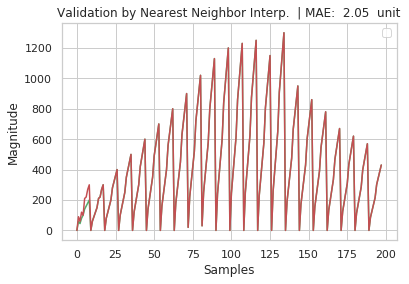

In [9]:
lookup_table_class.gridInterpolator(method = 'nearest')

# **Explanation of the above image**: With this new axis points, we can see difference with the previusly generated graph using the same algorithm. The MAE (Mean Absolute Error) is different.

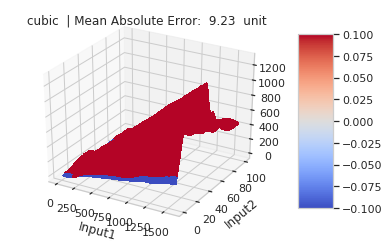

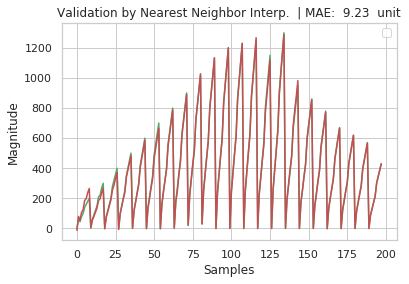

In [10]:
lookup_table_class.gridInterpolator(method = 'cubic')

# **Explanation of the above image**: With this new axis points, we can see difference with the previusly generated graph using the same algorithm. The MAE (Mean Absolute Error) was NaN ealier as interpolation was not proper. With the change in axis points, we get a correct fit.

# **Use case**: Thus the script can be used to perform experiment with different datasets and lookup table's axes points. The look up table generated can be directly used with SIMULINK 2D lookup Table. The names of the parameter files generated are given in the ReadMe file of the Github repo. 